## LightGBM

__Xgboost + 학습시간이 적게 걸림 + 메모리사용량이 적다__ <br>
- 더 빠른 학습과 예측 수행시간 + 더 적은 메모리 사용량 + 카테고리형 피처의 자동 변환과 최적 분할 +  <br>
- 하지만 적은 데이터 세트에 적용할 경우 과적합이 발생하기 쉽다.

__lightGBM은 리프 중심 트리 분할 방식을 사용한다.__ <br>

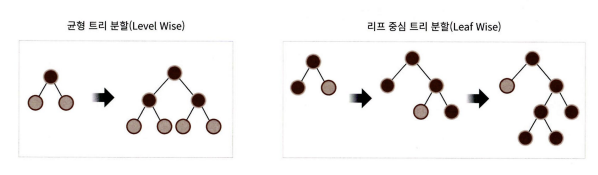

- 기존의 대부분 트리 기반 알고리즘은 '균형 트리 분할' 방식을 사용한다. 
    - 오버피팅에 보다 더 강한 구조를 가질 수 있다고 알려졌기 때문.

- lightGBM은 '리프 중심 트리 분할' 방식을 사용한다. 
    - 트리의 균형을 맞추지 않고, 최대 손실값(max delta loss)을 가지는 리프 노드를 지속적으로 분할하면서 트리의 깊이가 깊어지고 비대칭적인 규칙 트리가 생성된다. 하지만 이렇게 최대 손실값을 가지는 리프노드를 지속적으로 분할해 생성된 규칙 트리는 학습을 반복할 수록 결국은 균형 트리 분할 방식보다 예측 오류 손실을 최소화할 수 있다. 


__파라미터__

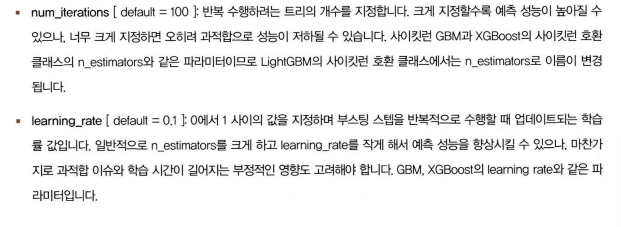 <br>
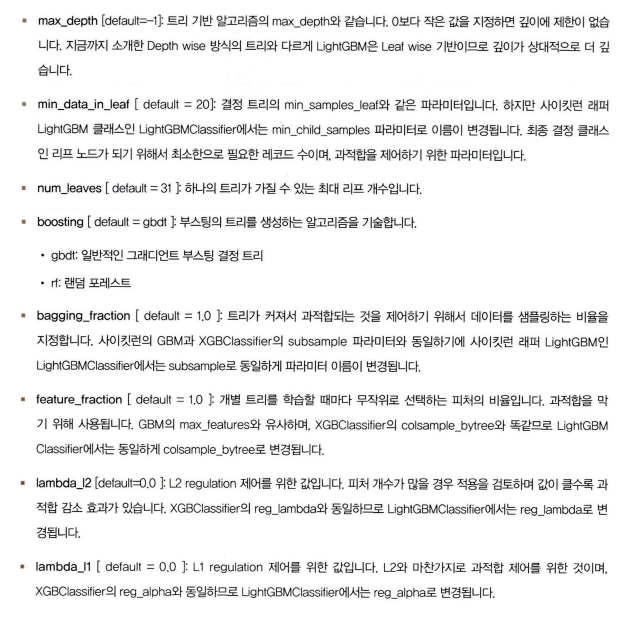 <br>


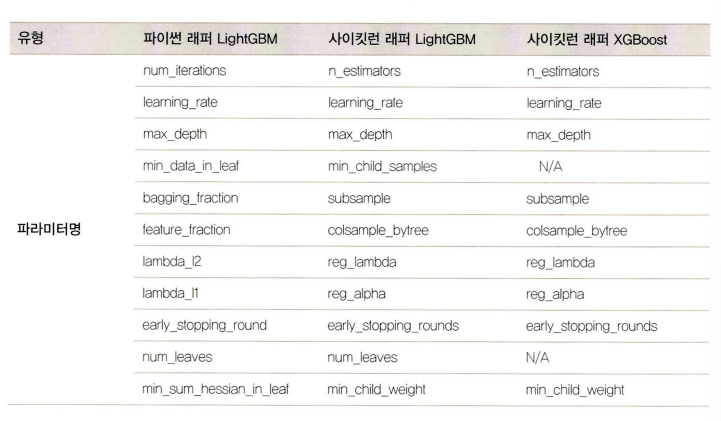


In [1]:
!pip install lightgbm


[notice] A new release of pip is available: 23.3.2 -> 24.0
[notice] To update, run: python.exe -m pip install --upgrade pip


### LightGBM - 유방암 예측 데이터

In [18]:
from lightgbm import LGBMClassifier

import pandas as pd
import numpy as np

from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
features = dataset.data
labels = dataset.target

cancer_df = pd.DataFrame(data=features, columns=dataset.feature_names)
cancer_df['target'] = labels
cancer_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,radius error,texture error,perimeter error,area error,smoothness error,compactness error,concavity error,concave points error,symmetry error,fractal dimension error,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,1.0950,0.9053,8.589,153.40,0.006399,0.04904,0.05373,0.01587,0.03003,0.006193,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,0.5435,0.7339,3.398,74.08,0.005225,0.01308,0.01860,0.01340,0.01389,0.003532,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,0.7456,0.7869,4.585,94.03,0.006150,0.04006,0.03832,0.02058,0.02250,0.004571,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,0.4956,1.1560,3.445,27.23,0.009110,0.07458,0.05661,0.01867,0.05963,0.009208,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,0.7572,0.7813,5.438,94.44,0.011490,0.02461,0.05688,0.01885,0.01756,0.005115,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [19]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
target
1    357
0    212
Name: count, dtype: int64


> 양성 benign이 357개, 악성 malignant가 212개

In [20]:
# cancer_df 에서 feature용 Dataframe과 Label용 Series 객체 추출
# 맨 마지막 칼럼이 Label 임. feature용 DataFrame은 cancer_df의 첫번째 칼럼에서 맨 마지막 두번째 컬럼까지를 :-1 슬라이싱으로 추출
X_features = cancer_df.iloc[:,:-1]
y_label = cancer_df.iloc[:,-1]

In [21]:
# 전체 데이터 중 80%는 학습용 데이터, 20%는 테스트용 데이터 추출
X_train, X_test, y_train, y_test = train_test_split(X_features, y_label, test_size=0.2, random_state=156)

# 위에서 만든 X_train, y_train을 다시 쪼개서 90%는 학습과 10%는 검증용 데이터로 분리
X_tr, X_val, y_tr, y_val = train_test_split(X_train, y_train, test_size=0.1, random_state=156)

print(X_train.shape, X_test.shape)
print(X_tr.shape, X_val.shape)

(455, 30) (114, 30)
(409, 30) (46, 30)


> 파이썬 래퍼 xgboost는 sklearn.XGBoost와 달리 XGBoost만의 전용 데이터 객체인 DMatrix를 사용한다. 때문에 numpy,pandas로 되어 있는 학습용, 검증, 테스트용 데이터 세트를 모두 전용의 데이터 객체인 DMatrix로 생성하여 모델에 입력해줘야 한다. DMatrix의 주요 입력 파라미터는 data와 label이다. data는 피처 데이터세트이며, label은 분류의 경우 레이블 데이터 세트, 회귀의 경우 숫자형인 종속형 데이터 세트

In [24]:
from lightgbm import early_stopping

> gbm_wrapper.fit(X_tr, y_tr,early_stopping_rounds=50, eval_metric='binary_logloss', eval_set=evals, verbose=True) 시 <br>
fit() got an unexpected keyword argument 'early_stopping_rounds' 오류 발생

> 해결 <br>
early_stopping import 후에 <br>
gbm_wrapper.fit(X_tr, y_tr,callbacks=[early_stopping(stopping_rounds=50)], eval_metric='binary_logloss', eval_set=evals)

In [26]:
lgbm_wrapper = LGBMClassifier(n_estimators=400, learning_rate=0.05)

# lgbm도 조기중단수행 가능
evals = [(X_tr, y_tr), (X_val, y_val)]
lgbm_wrapper.fit(X_tr, y_tr,callbacks=[early_stopping(stopping_rounds=50)], eval_metric='binary_logloss', eval_set=evals)
preds = lgbm_wrapper.predict(X_test)
pred_proba = lgbm_wrapper.predict_proba(X_test)[:,1]

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 251, number of negative: 158
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001077 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 4092
[LightGBM] [Info] Number of data points in the train set: 409, number of used features: 30
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.613692 -> initscore=0.462858
[LightGBM] [Info] Start training from score 0.462858
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 50 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Lig

> n_estimators를 400으로 설정했지만 early_stopping을 설정하여 61번만에 완료.

In [27]:
from sklearn.metrics import confusion_matrix, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

print('confusion_matrix:', confusion_matrix(y_test, preds))
print('정확도:', accuracy_score(y_test, preds))
print('정밀도:', precision_score(y_test, preds))
print('재현율:', recall_score(y_test, preds))
print('f1-score:', f1_score(y_test, preds))
print('roc_auc_score:', f1_score(y_test, preds))

confusion_matrix: [[34  3]
 [ 2 75]]
정확도: 0.956140350877193
정밀도: 0.9615384615384616
재현율: 0.974025974025974
f1-score: 0.967741935483871
roc_auc_score: 0.967741935483871


#### 피처의 중요도 시각화

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

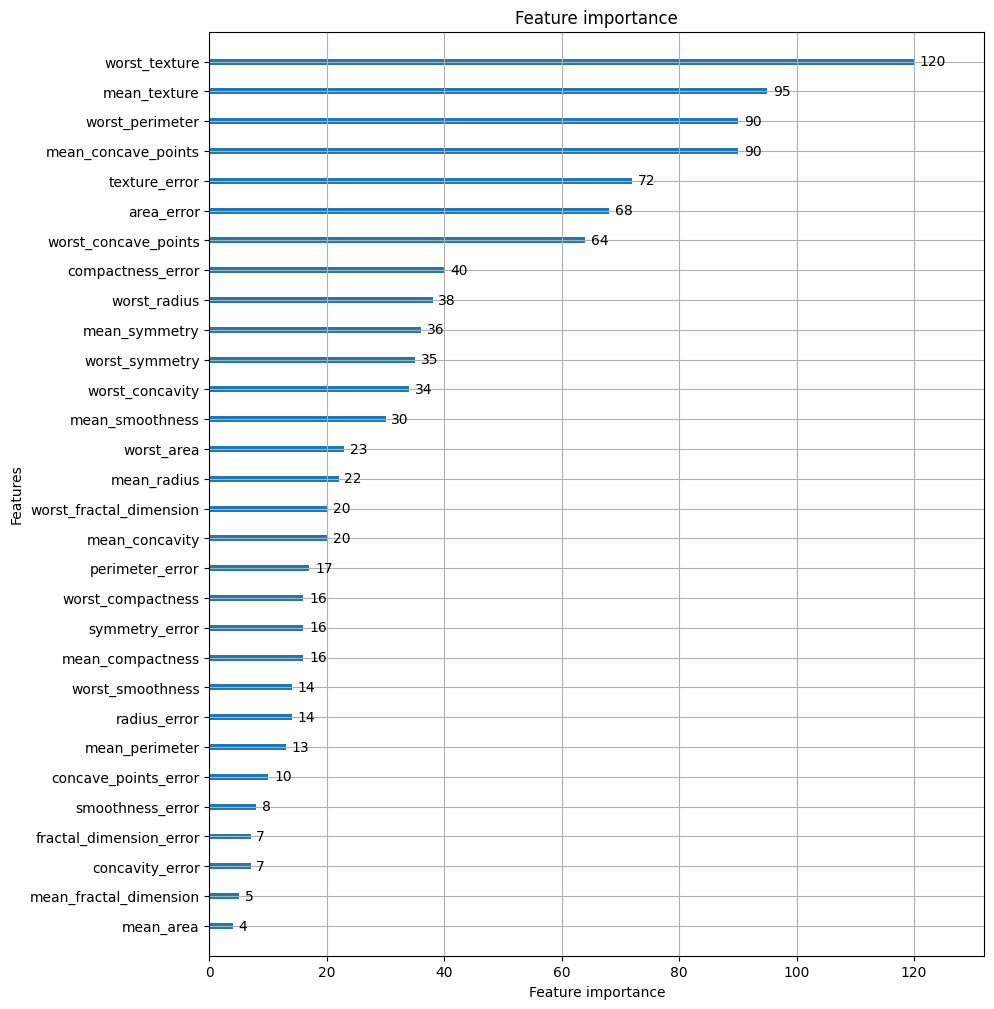

In [28]:
from lightgbm import plot_importance
import matplotlib.pyplot as plt

fig, ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)